# Combination of SEF, data augmentation and Tent for ResNet

The chosen ResNet model is trained on a modified Stanford Dogs dataset with only the 25 dog breeds that we have collected data for.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/Colab/SEF-master/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab/SEF-master/'
/content


In [3]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
# !conda install -q -y jupyter
# !conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py36" --user

--2022-05-06 20:31:21--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  55.76M   148MB/s    in 0.4s    

2022-05-06 20:31:21 (148 MB/s) - ‘mini.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 

In [3]:
!python --version

Python 3.6.5 :: Anaconda, Inc.


In [5]:
!pip install torch==1.7.1 torchvision==0.8.2

    100% |████████████████████████████████| 776.8MB 40kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x557779988000 @  0x7f01962eb2a4 0x55770f62ee25 0x7f0191ab5502 0x55770f629c20 0x55770f6b967c 0x55770f6dbcba 0x55770f6b370b 0x55770f6b9755 0x55770f6dbcba 0x55770f6b2a94 0x55770f6b3941 0x55770f6b9755 0x55770f6dbcba 0x55770f6b2a94 0x55770f6b3941 0x55770f6b9755 0x55770f6dbcba 0x55770f6b2a94 0x55770f6b3941 0x55770f6b9755 0x55770f6dca7a 0x55770f6b370b 0x55770f6b9755 0x55770f6dbcba 0x55770f6b2a94 0x55770f6b3941 0x55770f6b9755 0x55770f6dca7a 0x55770f6b2a94 0x55770f6b3941 0x55770f6b9755
    100% |████████████████████████████████| 12.8MB 3.1MB/s 
    100% |████████████████████████████████| 13.4MB 3.2MB/s 
    100% |████████████████████████████████| 49.4MB 949kB/s 
  Running setup.py bdist_wheel for pillow ... done
  Stored in directory: /root/.cache/pip/wheels/a7/69/9a/bba9fca6782340f88dbc378893095722a663cbc618e58fe401
Successfully built pillow


In [4]:
import os
import sys
import torch
print(torch.__version__)
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
import statistics
import torch.utils.model_zoo as model_zoo
# from .utils import load_state_dict_from_url
import pdb
import torch.nn.functional as torchf
# from utils.misc import SoftSigmoid
import pickle as pk
import uuid
import argparse
import torch.optim as opt
from torch.optim import lr_scheduler
import torch.multiprocessing as mlp
import torch.utils.tensorboard as tb
import copy
import time

1.11.0+cu113


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() > 0 else "cpu")
device_name = device.type+':'+str(device.index) if device.type=='cuda' else 'cpu'

In [6]:
progpath = '/content/drive/MyDrive/Capstone/SEF-master'
sys.path.append(progpath)

datasetname = 'stdogs25'
image_size = 448
batchsize = 32
nthreads = 4
lr = 1e-2
lmgm = 1
entropy = 1
soft = 0.05
epochs = 10
optmeth = 'sgd'
regmeth = 'cms'


# Number of attentions for different datasets
# nparts = 2 recommended for Stanford Dogs
nparts = 2


# 'resnet50attention' for SEF, 'resnet50maxent' for ResNet with MaxEnt, 'resnet50vanilla' for the vanilla ResNet
networkname = 'resnet50attention'
if networkname.find('attention') > -1:  # SEF based on ResNet
    attention_flag = True
    maxent_flag = False
elif networkname.find('maxent') > -1:   # ResNet with the maximum entropy regularization
    lmgm=soft=0
    nparts=1
    entropy=1
    attention_flag = False
    maxent_flag = True
else:                                   # The vanilla ResNet
    lmgm=entropy=soft=0
    nparts=1
    attention_flag = False
    maxent_flag = False


# Displaying logs
timeflag = time.strftime("%d-%b-%Y-%H:%M")
# writer = tb.SummaryWriter(log_dir='./runs/'+datasetname+'/'+networkname+time.strftime("%d-%b-%Y"))
log_items = r'{}-net{}-att{}-lmgm{}-entropy{}-soft{}-lr{}-imgsz{}-bsz{}'.format(
    datasetname, int(networkname[6:8]), nparts, lmgm, entropy, soft, lr, image_size, batchsize)
writer = tb.SummaryWriter(comment='-'+log_items)
logfile = open('./runs/'+log_items+'.txt', 'w')

###### MODEL NAME ######
modelname = log_items + '-aug' + '.model'


# Model zoo and dataset path
datapath = '/content/drive/MyDrive/Capstone/'
modelzoopath = '/content/drive/MyDrive/Capstone/SEF-master/'
sys.path.append(modelzoopath)
datasetpath = '/content/drive/MyDrive/Capstone/stdogs25'
modelpath = '/content/drive/MyDrive/Capstone/SEF-master/models'
resultpath = '/content/drive/MyDrive/Capstone/SEF-master/runs'

### Define transforms / augmentation for training

In [7]:
# Transforms for different subsets of stdogs25
# wyze, google and yt are our test sets
data_transform = {
    'train_aug': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(p=0.6),
        transforms.RandomRotation(degrees=30),
        transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.7),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train': transforms.Compose([
        transforms.Resize((600,600)),
        transforms.RandomCrop((448, 448)),
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])             
    ]),
    'wyze': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'yt': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'google': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

### Select test set, load data

In [8]:
# from utils.dataset import ConcatDataset, TensorDataset
# from utils.dataloader import DataLoader

#################################################################################
###### Select the test set for training, can reselect for evaluation later ######
#################################################################################
testset = 'wyze'
# testset = 'google'
# testset = 'yt'

# Augmented train set: original train set + transformed train set
# trainset = datasets.VisionDataset(os.path.join(datasetpath, 'train'))
# trans_trainset = datasets.VisionDataset(os.path.join(datasetpath, 'train'), transform=data_transform[testset])
# trainset = ConcatDataset([trainset])
# trans_trainset = ConcatDataset([trans_trainset])
# aug_trainset = torch.utils.data.ConcatDataset([trainset, trans_trainset])
# aug_trainset = torch.utils.data.Dataset(aug_trainset)

# Organizing datasets
# datasplits = {x: ImageFolder(os.path.join(datasetpath, x), data_transform[x])
#               for x in ['train', 'wyze']}
train = datasets.ImageFolder(os.path.join(datasetpath, 'train'), transform=data_transform['train'])
tran = datasets.ImageFolder(os.path.join(datasetpath, 'train'), transform=data_transform['train_aug'])

datasplits = {'train': torch.utils.data.ConcatDataset([train, tran]), 
              testset: datasets.ImageFolder(os.path.join(datasetpath, testset), transform=data_transform[testset])}

# Preparing dataloaders for datasets
# dataloader = {x: torch.utils.data.DataLoader(datasplits[x], batch_size=batchsize, shuffle=True, num_workers=nthreads)
#               for x in ['train', testset]}
dataloader = {x: torch.utils.data.DataLoader(datasplits[x], batch_size=batchsize, shuffle=True, num_workers=nthreads)
              for x in ['train', testset]}

datasplit_sizes = {x: len(datasplits[x]) for x in ['train', testset]}
# class_names = datasplits['train'].classes
# num_classes = len(class_names)

### Define the networks

In [9]:
eps = torch.finfo().eps
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']



model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [10]:
class LocalMaxGlobalMin(nn.Module):

    def __init__(self, rho, nchannels, nparts=1, device='cpu'):
        super(LocalMaxGlobalMin, self).__init__()
        self.nparts = nparts
        self.device = device
        self.nchannels = nchannels
        self.rho = rho      

        
        nlocal_channels_norm = nchannels // self.nparts
        reminder = nchannels % self.nparts
        nlocal_channels_last = nlocal_channels_norm
        if reminder != 0:
            nlocal_channels_last = nlocal_channels_norm + reminder
        
        # seps records the indices partitioning feature channels into separate parts
        seps = []
        sep_node = 0
        for i in range(self.nparts):
            if i != self.nparts-1:
                sep_node += nlocal_channels_norm                
                #seps.append(sep_node)
            else:
                sep_node += nlocal_channels_last                
            seps.append(sep_node)
        self.seps = seps
        


    def forward(self, x):  
        x = x.pow(2)
        intra_x = []
        inter_x = []
        for i in range(self.nparts):
            if i == 0:        
                intra_x.append((1 - x[:, :self.seps[i], :self.seps[i]]).mean()) 
            else:              
                intra_x.append((1 - x[:, self.seps[i-1]:self.seps[i], self.seps[i-1]:self.seps[i]]).mean())
                inter_x.append(x[:, self.seps[i-1]:self.seps[i], :self.seps[i-1]].mean())
        
        loss = self.rho * 0.5 * (sum(intra_x) / self.nparts + sum(inter_x) / (self.nparts*(self.nparts-1)/2)) 
                 

        return loss
        

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

       
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [12]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, nparts=0, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, attention=False, device='cpu'):
        super(ResNet, self).__init__()

        self.attention = attention
        self.device = device
        self.nparts = nparts

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        if self.attention:            
            nfeatures = 512 * block.expansion            
            nlocal_channels_norm = nfeatures // self.nparts
            reminder = nfeatures % self.nparts
            nlocal_channels_last = nlocal_channels_norm
            if reminder != 0:
                nlocal_channels_last = nlocal_channels_norm + reminder
            fc_list = []
            separations = []
            sep_node = 0
            for i in range(self.nparts):
                if i != self.nparts-1:
                    sep_node += nlocal_channels_norm
                    fc_list.append(nn.Linear(nlocal_channels_norm, num_classes))
                    #separations.append(sep_node)
                else:
                    sep_node += nlocal_channels_last
                    fc_list.append(nn.Linear(nlocal_channels_last, num_classes))
                separations.append(sep_node)
            self.fclocal = nn.Sequential(*fc_list)
            self.separations = separations 
            self.fc = nn.Linear(512*block.expansion, num_classes) 

        else:            
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
  
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) 
        x = self.layer4(x)

        if self.attention:

            nsamples, nchannels, height, width = x.shape
        
            xview = x.view(nsamples, nchannels, -1)
            xnorm = xview.div(xview.norm(dim=-1, keepdim=True)+eps)
            xcosin = torch.bmm(xnorm, xnorm.transpose(-1, -2))                               
            

            attention_scores = []
            for i in range(self.nparts):
                if i == 0:
                    xx = x[:, :self.separations[i]]
                else:
                    xx = x[:, self.separations[i-1]:self.separations[i]]
                xx_pool = self.avgpool(xx).flatten(1)
                attention_scores.append(self.fclocal[i](xx_pool))
            xlocal = torch.stack(attention_scores, dim=0)

            xmaps = x.clone().detach()
            
            # for global
            xpool = self.avgpool(x)
            xpool = torch.flatten(xpool, 1)
            xglobal = self.fc(xpool)

            
            return xglobal, xlocal, xcosin, xmaps
        else:
            # for original resnet outputs
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

            return x

In [13]:
def _resnet(arch, block, layers, pretrained, progress, model_dir=None, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls[arch], model_dir=model_dir))
        state_dict = torch.hub.load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, model_dir=None, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress, model_dir,
                   **kwargs)


def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, model_dir=None, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress, model_dir,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained=False, progress=True, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained=False, progress=True, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


In [14]:
num_classes = 25
model = resnet50(pretrained=False, model_dir=modelzoopath, nparts=nparts, num_classes=num_classes, attention=attention_flag, device=device)
state_dict_path = os.path.join(modelzoopath, "resnet50-19c8e357.pth")

state_params = torch.load(state_dict_path)

# pop redundant params from laoded states
state_params.pop('fc.weight')
state_params.pop('fc.bias')

# modify output layer
in_channels = model.fc.in_features
new_fc = nn.Linear(in_channels, num_classes, bias=True)
model.fc = new_fc

# initializing model using pretrained params except the modified layers
model.load_state_dict(state_params, strict=False)
 

# tensorboard writer
images, _ = next(iter(dataloader[testset]))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid)
writer.add_graph(model, images)

# to gpu if available
model.cuda(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Define loss function and optimizer

In [15]:
cls_loss = nn.CrossEntropyLoss()

# Semantic group loss
lmgm_loss = LocalMaxGlobalMin(rho=lmgm, nchannels=512*4, nparts=nparts, device=device)

criterion = [cls_loss, lmgm_loss]

In [16]:
optimizer = opt.SGD(model.parameters(), lr=lr, momentum=0.9)

# Optimization scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

### Train a model

In [19]:
softmax = nn.Softmax(dim=-1)
logsoftmax = nn.LogSoftmax(dim=-1)
kldiv = nn.KLDivLoss(reduction='batchmean')


def train(model, dataloader, criterion, optimizer, scheduler, datasetname=None, isckpt=False, epochs=5, networkname=None, writer=None, maxent_flag=False, device='cpu', **penalty):
    
    output_log_file = penalty['logfile']
    nparts = model.nparts
    attention_flag = model.attention
    
    if isinstance(dataloader, dict):
        dataset_sizes = {x: len(dataloader[x].dataset) for x in dataloader.keys()}
        print(dataset_sizes)
    else:
        dataset_size = len(dataloader.dataset)

    if not isinstance(criterion, list):
        criterion = [criterion]

    best_model_params = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    global_step = 0
    global_step_resume = 0
    best_epoch = 0
    best_step = 0
    start_epoch = -1
    

    # if isckpt:
    #     checkpoint = modelserial.loadCheckpoint(datasetname+'-'+networkname)

    #     # records for the stopping epoch
    #     start_epoch = checkpoint['epoch']
    #     global_step_resume = checkpoint['global_step']
    #     model.load_state_dict(checkpoint['state_dict'])

    #     # records for the epoch with the best performance
    #     best_model_params = checkpoint['best_state_dict']
    #     best_acc = checkpoint['best_acc']
    #     best_epoch = checkpoint['best_epoch']
    #     optimizer.param_groups[0]['lr'] = checkpoint['current_lr']

    since = time.time()
    for epoch in range(start_epoch+1, epochs):

        # print to file
        print('Epoch {}/{}'.format(epoch, epochs), file=output_log_file)
        print('-' * 10, file=output_log_file)

        # print to terminal
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)


        for phase in ['train', testset]:
            if phase == 'train':
                # scheduler.step()
                model.train()  # Set model to training mode
                global_step = global_step_resume
            else:
                model.eval()   # Set model to evaluate mode
                global_step_resume = global_step

            running_cls_loss = 0.0
            running_reg_loss = 0.0
            running_corrects = 0.0
            running_corrects_parts = [0.0] * nparts
            epoch_acc_parts = [0.0] * nparts


            for inputs, labels in dataloader[phase]:
                inputs = inputs.cuda(device)
                labels = labels.cuda(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):

                    if attention_flag:
                        # outputs are logits from linear models
                        xglobal, xlocal, xcosin, xmaps = model(inputs)
                        # attmaps.append([xglobal, xlocal, xcosin, xmaps])
                        probs = softmax(xglobal)                    
                        cls_loss = criterion[0](xglobal, labels)

                        ############################################################## prediction

                        # prediction of every  branch
                        probl, predl, logprobl = [], [], []
                        for i in range(nparts):
                            probl.append(softmax(torch.squeeze(xlocal[i])))
                            predl.append(torch.max(probl[i], 1)[-1])
                            logprobl.append(logsoftmax(torch.squeeze(xlocal[i])))


                        ############################################################### regularization

                        logprobs = logsoftmax(xglobal)
                        entropy_loss = penalty['entropy_weights'] * torch.mul(probs, logprobs).sum().div(inputs.size(0))
                        soft_loss_list = []
                        for i in range(nparts):
                            soft_loss_list.append(torch.mul(torch.neg(probs), logprobl[i]).sum().div(inputs.size(0)))
                        soft_loss = penalty['soft_weights'] * sum(soft_loss_list).div(nparts)

                        # regularization loss
                        lmgm_reg_loss = criterion[1](xcosin)
                        reg_loss = lmgm_reg_loss + entropy_loss + soft_loss


                    else:
                        outputs = model(inputs)
                        probs = softmax(outputs)
                        cls_loss = criterion[0](outputs, labels)
                        if maxent_flag:
                            logprobs = logsoftmax(outputs)
                            reg_loss = torch.mul(probs, logprobs).sum().neg().div(inputs.size(0))
                        else:
                            reg_loss = torch.tensor(0.0)

 
                    _, preds = torch.max(probs, 1)   # the indeices of the largeset value in each row   

                    all_loss = cls_loss + reg_loss
                    
                    if phase == 'train':                       
                        all_loss.backward()
                        optimizer.step()

                # statistics
                running_cls_loss += (cls_loss.item()) * inputs.size(0)
                running_reg_loss += (reg_loss.item()) * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if attention_flag:
                    for i in range(nparts):
                        running_corrects_parts[i] += torch.sum(predl[i] == labels.data)
                    
                # log variables
                global_step += 1
                if global_step % 100 == 1 and writer is not None and phase is 'train':
                    batch_loss = cls_loss.item() + reg_loss.item() 
                    writer.add_scalar('running loss/running_train_loss', batch_loss, global_step)
                    writer.add_scalar('running loss/running_cls_loss', cls_loss, global_step) 
                    if attention_flag:                     
                        writer.add_scalar('running loss/running_lmgm_reg_loss', lmgm_reg_loss, global_step)  
                        writer.add_scalar('running loss/running_entropy_reg_loss', entropy_loss, global_step)  
                        writer.add_scalar('running loss/running_soft_reg_loss', soft_loss, global_step)  
                    elif maxent_flag:
                        writer.add_scalar('running loss/running_maxent_reg_loss', reg_loss, global_step)  
                    for name, param in model.named_parameters():
                        writer.add_histogram('params_in_running/'+name, param.data.clone().cpu().numpy(), global_step)     # global_step



            ############################################### for each epoch
            
            # epoch loss and accuracy
            epoch_loss = running_cls_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if attention_flag:
                for i in range(nparts):
                    epoch_acc_parts[i] = running_corrects_parts[i].double() / dataset_sizes[phase]


            # log variables for each epoch
            if writer is not None:
                if phase is 'train':
                    writer.add_scalar('epoch loss/train_epoch_loss', epoch_loss, epoch)        # global_step
                    writer.add_scalar('accuracy/train_epoch_acc', epoch_acc, epoch)          # global_step
                    if attention_flag:
                        for i in range(nparts):
                            writer.add_scalar('accuracy/train_acc_part{}_acc'.format(i), epoch_acc_parts[i], epoch) 
                    for name, param in model.named_parameters():
                        writer.add_histogram('params_in_epoch/'+name, param.data.clone().cpu().numpy(), epoch)     # global_step
                elif phase is testset:
                    writer.add_scalar('epoch loss/eval_epoch_loss', epoch_loss, epoch)         # global_step_resume
                    writer.add_scalar('accuracy/eval_epoch_acc', epoch_acc, epoch)          # global_step_resume
                    if attention_flag:
                        for i in range(nparts):
                            writer.add_scalar('accuracy/eval_acc_part{}_acc'.format(i), epoch_acc_parts[i], epoch) 

            # print to log file
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), file=output_log_file)
            if phase == 'train': print('current lr: {}'.format(optimizer.param_groups[0]['lr']), file=output_log_file)
            if phase == testset: print('\n', file=output_log_file)

            # print to terminal
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'train': print('current lr: {}'.format(optimizer.param_groups[0]['lr']))

            # deep copy the model
            if phase == testset and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_step = global_step_resume
                best_model_params = copy.deepcopy(model.state_dict())

            # if phase == 'wyze' and epoch % 5 == 1:
            #     modelserial.saveCheckpoint({'epoch': epoch,
            #                                 'global_step': global_step,
            #                                 'state_dict': model.state_dict(),
            #                                 'best_epoch': best_epoch,
            #                                 'best_state_dict': best_model_params,
            #                                 'best_acc': best_acc, 
            #                                 'current_lr': optimizer.param_groups[0]['lr']},datasetname+'-'+networkname)
        
        # adjust learning rate after each epoch
        scheduler.step()

        
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60), file=output_log_file)
    print('Best test Acc: {:4f}'.format(best_acc) , file=output_log_file)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best test Acc: {:4f}'.format(best_acc))


    # recording training params
    rsltparams = dict()
    rsltparams['datasetname'] = datasetname
    rsltparams['nparts'] = model.nparts
    rsltparams['val_acc'] = best_acc.item()
    rsltparams['lmgm'] = criterion[1].rho
    rsltparams['lr'] = optimizer.param_groups[0]['lr']
    rsltparams['best_epoch'] = best_epoch
    rsltparams['best_step'] = best_step
    rsltparams['soft_weights'] = penalty['soft_weights']
    rsltparams['entropy_weights'] = penalty['entropy_weights']
    # rsltparams['attmaps'] = attmaps

    # load best model weights
    model.load_state_dict(best_model_params)
    return model, rsltparams

In [20]:
isckpt = False  # set True to load learned models from checkpoint, defatult False

indfile = "{}: opt={}, lr={}, lmgm={}, nparts={}, entropy={}, soft={}, epochs={}, imgsz={}, batch_sz={}".format(
    datasetname, optmeth, lr, lmgm, nparts, entropy, soft, epochs, image_size, batchsize)
print("\n{}\n".format(indfile))
print("\n{}\n".format(indfile), file=logfile)


model, train_rsltparams = train(
    model, dataloader, criterion, optimizer, scheduler, 
    datasetname=datasetname, isckpt=isckpt, epochs=epochs, 
    networkname=networkname, writer=writer, device=device, maxent_flag=maxent_flag,
    soft_weights=soft, entropy_weights=entropy, logfile=logfile)


train_rsltparams['imgsz'] = image_size
train_rsltparams['epochs'] = epochs
train_rsltparams['init_lr'] = lr
train_rsltparams['batch_sz'] = batchsize

print('\nBest epoch: {}'.format(train_rsltparams['best_epoch']))
print('\nBest epoch: {}'.format(train_rsltparams['best_epoch']), file=logfile)
print("\n{}\n".format(indfile))
print("\n{}\n".format(indfile), file=logfile)
print('\nWorking on cluster: {}\n'.format(device_name))

logfile.close()


#################################################################################################################### save model
torch.save({'model_params':model.state_dict(), 'train_params':train_rsltparams}, os.path.join(modelpath, modelname))


stdogs25: opt=sgd, lr=0.01, lmgm=1, nparts=2, entropy=1, soft=0.05, epochs=10, imgsz=448, batch_sz=32

{'train': 8430, 'wyze': 1817}
Epoch 0/10
----------
train Loss: 1.5017 Acc: 0.7765
current lr: 0.01
wyze Loss: 2.9846 Acc: 0.1095

Epoch 1/10
----------
train Loss: 1.3541 Acc: 0.8759
current lr: 0.01
wyze Loss: 3.3038 Acc: 0.1101

Epoch 2/10
----------
train Loss: 1.2749 Acc: 0.9094
current lr: 0.01
wyze Loss: 3.0838 Acc: 0.0985

Epoch 3/10
----------
train Loss: 1.2304 Acc: 0.9259
current lr: 0.01
wyze Loss: 3.1264 Acc: 0.1134

Epoch 4/10
----------
train Loss: 1.1963 Acc: 0.9381
current lr: 0.01
wyze Loss: 3.1302 Acc: 0.1233

Epoch 5/10
----------
train Loss: 1.1607 Acc: 0.9520
current lr: 0.01
wyze Loss: 3.0800 Acc: 0.1475

Epoch 6/10
----------
train Loss: 1.1364 Acc: 0.9605
current lr: 0.01
wyze Loss: 2.9126 Acc: 0.1497

Epoch 7/10
----------
train Loss: 1.1217 Acc: 0.9643
current lr: 0.01
wyze Loss: 3.0936 Acc: 0.1233

Epoch 8/10
----------
train Loss: 1.0972 Acc: 0.9759
curre

### Load a model and evaluate it

In [51]:
!nvidia-smi

Fri May  6 21:06:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |  14954MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
!kill process_id

/bin/bash: line 0: kill: process_id: arguments must be process or job IDs


In [53]:
torch.cuda.clear_cache

AttributeError: ignored

In [20]:
cd /content/drive/MyDrive/Capstone/SEF-master/

/content/drive/MyDrive/Capstone/SEF-master


In [17]:
softmax = nn.Softmax(dim=-1)
logsoftmax = nn.LogSoftmax(dim=-1)
kldiv = nn.KLDivLoss(reduction='batchmean')

In [57]:
def eval(model, dataloader=None, device='cpu', datasetname=None):

    if not datasetname or datasetname not in ['cubbirds', 'stcars', 'stdogs', 'vggaircraft', 'nabirds', 'wyzedogs', 'wyze', 'yt', 'google', 'stdogs25']:
        print("illegal dataset")
        return
    
    attention_flag = model.attention
    model.eval()
    datasize = len(dataloader.dataset)
    running_corrects = 0
    good_data = []
    bad_data = []
    maps = []
    lab = []
    inp = []
    num_label_counts = dict()
    pred_label_counts = dict()
    

    for inputs, labels in dataloader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            if attention_flag:
                outputs, xlocal, xcosin, xmaps = model(inputs)
            else:
                outputs = model(inputs)

        # Save xmaps, inputs and labels in lists
        # Return them with result parameters
        maps.append(xmaps.cpu().numpy())
        lab.append(labels.cpu().numpy())
        inp.append(inputs.cpu().numpy())
                
        probs = softmax(outputs)
        _, preds = torch.max(probs, 1)

        running_corrects += torch.sum(preds == labels.data)

        # record paths and labels
        good_mask = preds == labels.data
        bad_mask = torch.logical_not(good_mask)
        good_index = good_mask.nonzero()
        bad_index = bad_mask.nonzero()
        # for idx in good_index:
        #     good_data.append((paths[idx], labels[idx].item()))
        # for idx in bad_index:
        #     bad_data.append((paths[idx], labels[idx].item()))

    
    acc = torch.div(running_corrects.double(), datasize).item()
    avg_acc = 0.0
    print("General Accuracy: {}".format(acc))


    rsltparams = dict()
    rsltparams['acc'] = acc
    rsltparams['avg_acc'] = avg_acc
    rsltparams['good_data'] = good_data
    rsltparams['bad_data'] = bad_data
    rsltparams['xlocal'] = xlocal
    rsltparams['xcosin'] = xcosin
    rsltparams['xmaps'] = maps
    rsltparams['outputs'] = outputs
    rsltparams['labels'] = lab
    rsltparams['inputs'] = inp
    
    return rsltparams

In [58]:
# Import undistort transform
# Must be used before resize transform because it accepts (1920, 1080) Wyze Cam images
# Only use undistort on wyze set
from undistort import undistort
import cv2
# from utils.mydataloader import DataLoader

eps = torch.finfo().eps
device = torch.device("cuda:0" if torch.cuda.is_available() > 0 else "cpu")
progpath = '/content/drive/MyDrive/Capstone/SEF-master'
sys.path.append(progpath)
datapath = '/content/drive/MyDrive/Capstone/'
modelzoopath = '/content/drive/MyDrive/Capstone/SEF-master/models/'
sys.path.append(os.path.realpath(modelzoopath))
modelpath = os.path.join(progpath, 'models')
resultpath = os.path.join(progpath, 'runs')
datasetname = 'stdogs25'

# modelname = r'stdogs-net50-att1-lmgm0-entropy0-soft0-lr0.01-imgsz448-bsz32.model' # ResNet-50 base model
# modelname = r'stdogs-net50-att2-lmgm1-entropy1-soft0.05-lr0.01-imgsz448-bsz32.model' # ResNet-50 with SEF
# modelname = r'stdogs25-net50-att2-lmgm1-entropy1-soft0.05-lr0.01-imgsz448-bsz32.model' # ResNet-50 with SEF trained on stdogs25, no augmentation
modelname = r'stdogs25-net50-att2-lmgm1-entropy1-soft0.05-lr0.01-imgsz448-bsz32-aug.model' # ResNet-50 with SEF trained on stdogs25, with augmentation

load_params = torch.load(os.path.join(modelpath, modelname), map_location=device)
networkname = modelname.split('-')[1]

model_state_dict, train_params = load_params['model_params'], load_params['train_params']

nparts = train_params['nparts']
lmgm = train_params['lmgm']
entropy = train_params['entropy_weights']
soft = train_params['soft_weights']
batchsize = train_params['batch_sz']
imgsz = train_params['imgsz']
lr = train_params['init_lr']
if datasetname == 'stdogs': num_classes = 120
if datasetname == 'stdogs25': num_classes = 25
attention_flag = True if nparts > 1 else False
netframe = 'resnet50' if networkname.find('50') > -1 else 'resnet18'
model = resnet50(pretrained=False, model_dir=modelzoopath, nparts=nparts, num_classes=num_classes, attention=attention_flag, device=device)
model.load_state_dict(model_state_dict, strict=True)
model.to(device)


datasetpath = os.path.join(datapath, datasetname)

data_transform = {
    'train': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomRotation(degrees=30),
        transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 2.0)),
        transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomPerspective(distortion_scale=0.5, p=0.25),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'wyze': transforms.Compose([
        transforms.Lambda(undistort),
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'yt': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'google': transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# testset = 'wyze'
testset = 'google'
# testset = 'yt'

test_transform = data_transform[testset]

testsplit = ImageFolder(os.path.join(datasetpath, testset), data_transform[testset])
testloader = DataLoader(testsplit, batch_size=64, shuffle=False, num_workers=4)
test_rsltparams = eval(model, testloader, datasetname=datasetname, device=device)

print('General Acc: {}, Class Avg Acc: {}'.format(test_rsltparams['acc'], test_rsltparams['avg_acc']))

General Accuracy: 0.9142011834319527
General Acc: 0.9142011834319527, Class Avg Acc: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 2048, 14, 14)
(64,)
(64, 3, 448, 448)


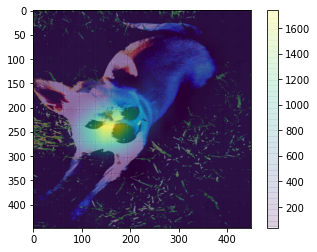

In [75]:
import cv2

idx = 24
data = test_rsltparams['xmaps'][0]
labels = test_rsltparams['labels'][0]
inputs = test_rsltparams['inputs'][0]
print(np.shape(data))
print(np.shape(labels))
print(np.shape(inputs))

# Get activation map
att1 = data[idx, 0, :, :]
for i in range(1, 1024):
  att1 = np.add(att1, data[idx, i, :, :])
att1 = cv2.resize(att1, (448, 448))

att2 = data[idx, 1024, :, :]
for i in range(1025, 2048):
  att2 = np.add(att2, data[idx, i, :, :])
att2 = cv2.resize(att2, (448, 448))

att = 0.5 * att1 + 0.5 * att2

# Get input image
im = inputs[idx]
im = im.swapaxes(0, 1)
im = im.swapaxes(1, 2)


fig, ax = plt.subplots(1)
# Plot image
ax.imshow(im)
# Plot pcolormhesh of activation map
p = ax.pcolormesh(att, alpha=0.1, cmap='viridis')
fig.colorbar(p, ax=ax)

### Apply tent to loaded model

In [62]:
# ! git clone https://github.com/DequanWang/tent.git

In [63]:
import tent.tent as tent

model = tent.configure_model(model)
params, param_names = tent.collect_params(model)
# optimizer = torch.optim.SGD(params, lr=1e-3)
tented_model = tent.Tent(model, optimizer)
# print(tent.check_model(tented_model))
# print(tented_model)

In [64]:
tented_model.eval()
datasize = len(testloader.dataset)
running_corrects = 0
good_data = []
bad_data = []
num_label_counts = dict()
pred_label_counts = dict()


for inputs, labels in testloader:

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs, _, _, _ = model(inputs)
            
    probs = softmax(outputs)
    _, preds = torch.max(probs, 1)
    # print(preds)

    running_corrects += torch.sum(preds == labels.data)

    # record paths and labels
    good_mask = preds == labels.data
    bad_mask = torch.logical_not(good_mask)
    good_index = good_mask.nonzero()
    bad_index = bad_mask.nonzero()
    # for idx in good_index:
    #     good_data.append((paths[idx], labels[idx].item()))
    # for idx in bad_index:
    #     bad_data.append((paths[idx], labels[idx].item()))


acc = torch.div(running_corrects.double(), datasize).item()
avg_acc = 0.0
print("General Accuracy: {}".format(acc))

General Accuracy: 0.12328013208585581
